In [1]:
import numpy as np
from scipy.special import gamma
from scipy.special import comb
import matplotlib.pyplot as plt

# 1. Binomial Distribution

$$Bin(m \vert N, \mu) = \begin{pmatrix}N \\ m\end{pmatrix}\mu^m(1-\mu)^{N-m}$$

* likelihood: what parameter is likely to be to explain the observed data
* change $N$ to $l+m$

$$\begin{aligned}L(\mu) &= Bin(\mu \vert m, l) \\
&=\begin{pmatrix} l+m \\ m\end{pmatrix}\mu^m(1-\mu)^l
\end{aligned}$$

## 1.1 MLE

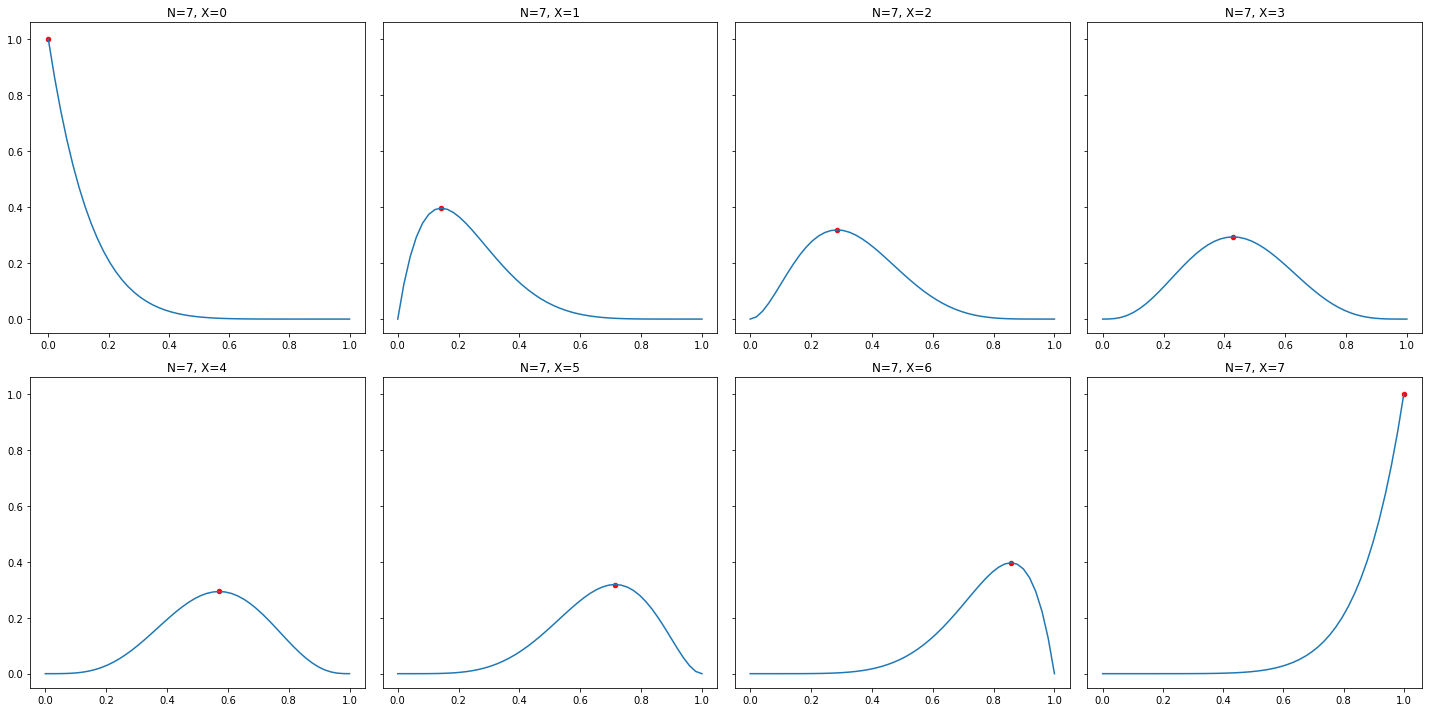

In [2]:
def Binomial(mu, n, m):
    """
    mu: probability
    n: number of trials
    m: counts of random variable X is 1
    """
    return comb(n, m) * (mu**m) * (1-mu)**(n-m)

probs = np.linspace(0, 1, num=50)
N = 7
X = np.arange(0, N+1)

fig, axes = plt.subplots(2, (N+1)//2, figsize=(20, 10), sharey=True)
for x, ax in zip(X, axes.flatten()):
    L = Binomial(probs, N, x)
    max_y, max_x = L.max(), probs[L.argmax()]
    ax.plot(probs, L)
    ax.scatter(max_x, max_y, s=20, c="red")
    ax.set_title(f"N={N}, X={x}")
plt.tight_layout()
plt.show()

## 1.2 Bayesian 

### Beta Distribution

$$Beta(\mu \vert a, b)=\dfrac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\mu^{a-1}(1-\mu)^{b-1}$$

gamma function

$$\Gamma(x)=\int_0^{\infty}u^{x-1}e^{-u}du$$

In [3]:
def Beta(mu, a, b):
    return gamma(a + b)/(gamma(a)*gamma(b)) * mu**(a-1) * (1-mu)**(b-1)

/home/simonjisu/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


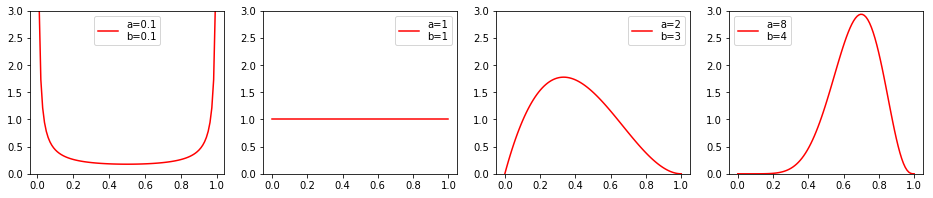

In [4]:
aa = [0.1, 1, 2, 8]
bb = [0.1, 1, 3, 4]
probs = np.linspace(0, 1, num=100)

fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=False)
for ax, a, b in zip(axes, aa, bb):
    beta_value = Beta(probs, a, b)
    ax.plot(probs, beta_value, c="red", label=f"a={a}\nb={b}")
    ax.set_ylim(0, 3)
    ax.legend()

### Calculate Posterior

$$\text{posterior} \propto \text{likelihood}\times \text{prior}$$

$$p(\mu \vert m, l, a, b) = L(\mu \vert m, l) \times Beta(\mu \vert a, b)$$

In [5]:
def Posterior(theta, m, l, a, b):
    return gamma(m+a+l+b)/(gamma(m+a)*gamma(l+b))*theta**(m+a-1)*(1-theta)**(l+b-1)

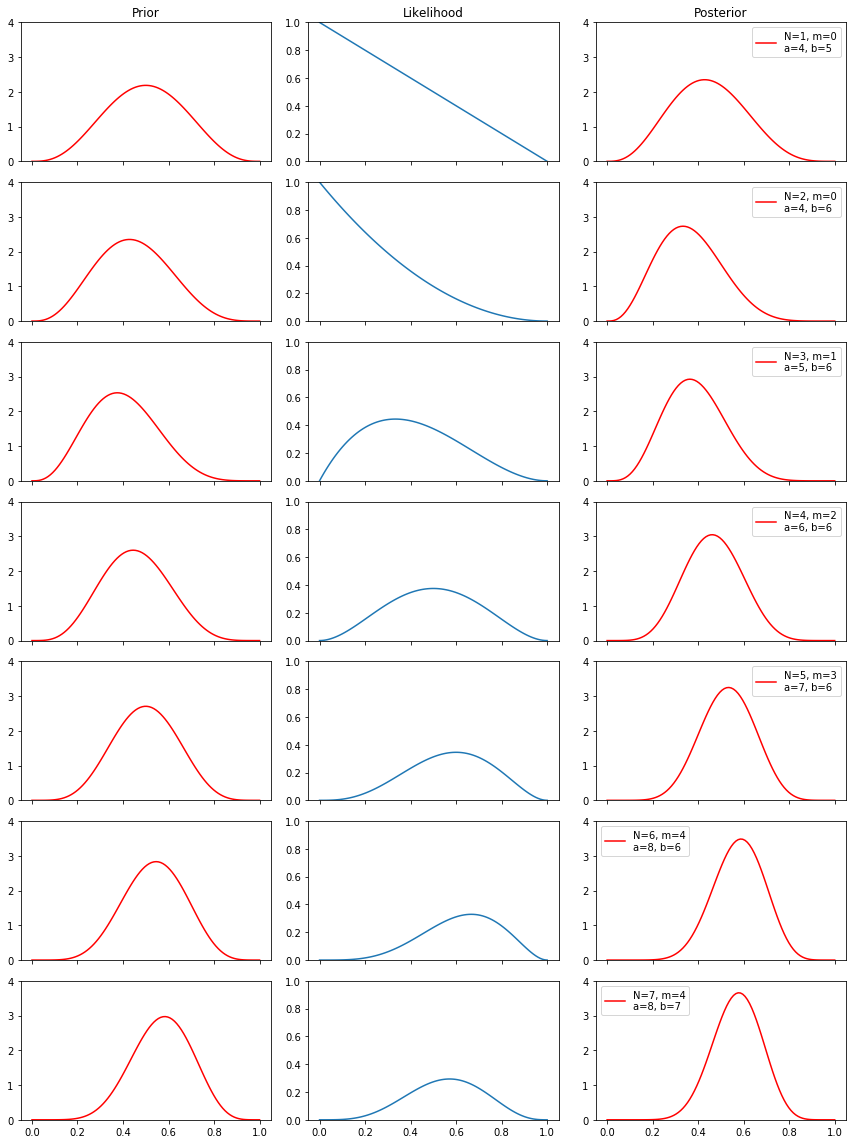

In [6]:
a, b = (4, 4)  # init hyperparameters

X = np.array([0, 0, 1, 1, 1, 1, 0])  # observed data
probs = np.linspace(0, 1, num=100)
fig, axes = plt.subplots(len(X), 3, figsize=(12, 16), sharex=True, sharey=False)

# online update given single data
m = 0
for i, (x, row_axes) in enumerate(zip(X, axes)):
    if x == 1:
        m += 1
    likelihood = Binomial(probs, i+1, m)
    prior = Beta(probs, a, b)
    post = Posterior(probs, m, (i+1)-m, a, b)
    if x == 1:
        a += 1
    else:
        b += 1
        
    # draw
    if i == 0:
        row_axes[0].set_title("Prior")
        row_axes[1].set_title("Likelihood")
        row_axes[2].set_title("Posterior")
    row_axes[0].plot(probs, prior, c="red")
    row_axes[1].plot(probs, likelihood)
    row_axes[2].plot(probs, post, c="red", label=f"N={i+1}, m={m}\na={a}, b={b}")
    row_axes[0].set_ylim(0, 4)
    row_axes[1].set_ylim(0, 1)
    row_axes[2].set_ylim(0, 4)
    row_axes[2].legend()
plt.tight_layout()
plt.show()

---

# 2. Gaussian Distribution

* single variable

$$\mathcal{N}(x \vert \mu, \sigma^2)=\dfrac{1}{(2\pi \sigma^2)^{1/2}} \exp \big\{-\dfrac{1}{2\sigma^2}(x-\mu)^2\big\}$$

* multi variables

$$\begin{aligned} \mathcal{N}(x \vert \mu, \Sigma^2) &=\dfrac{1}{(2\pi)^{D/2}} \dfrac{1}{\vert\Sigma\vert^{1/2}} \exp \big\{-\dfrac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\big\} \\
&=\dfrac{1}{(2\pi)^{D/2}} \dfrac{1}{\vert\Sigma\vert^{1/2}} \exp \big\{-\Delta^2\big\} 
\end{aligned}$$

In [7]:
def Gaussian(x, mean, cov):
    """
    x : last dimension must be number of variable demension (*batch, 1, D), D is dimension of random variable x
        For instance 1-D shape should be (N, 1, 1)
        support if `x.ndim == 1` automatically change to (batch, 1, 1)
    mean : D-dimension mean vector
    cov : covariance
    """
    assert isinstance(x, np.ndarray), "input must be np.ndarray"
    # change dimension for 1-D array
    if x.ndim == 1:
        x = x.reshape(x.size, 1, 1)
        if not isinstance(cov, np.ndarray):
            cov = np.array([[cov]])
        elif (cov.ndim == 1):
            cov = cov.reshape(1, 1)
    assert x.shape[-2] == 1, "must be a row vector, so x.shape[-2]==1"
    D = x.shape[-1]
    N_dims = len(x.shape)
    # mahalanobis distance: \Delta^2
    trans_axes = list(range(N_dims-2)) + [N_dims-1, N_dims-2]
    distance = np.squeeze((1/2)*np.matmul((x - mean).dot(np.linalg.inv(cov)), np.transpose((x - mean), axes=trans_axes)))
    return (2*np.pi)**(-D/2)*np.linalg.det(cov)**(-1/2)*np.exp(-distance)

### Single Variable

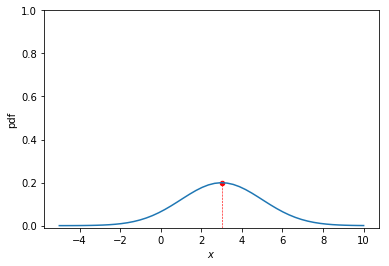

In [8]:
N = 50
mu = 3
var = 4
x = np.linspace(-5, 10, num=N)
y = Gaussian(x, mean=mu, cov=var)
plt.scatter(mu, Gaussian(np.array([mu]), mean=mu, cov=var), c="r", s=20)
plt.plot((mu, mu), (-0.01, Gaussian(np.array([mu]), mean=mu, cov=var)), "r--", linewidth=0.6)
plt.plot(x, y)
plt.ylim(-0.01, 1)
plt.xlabel("$x$")
plt.ylabel("pdf")
plt.show()

### Multivariate Gaussian Distribution

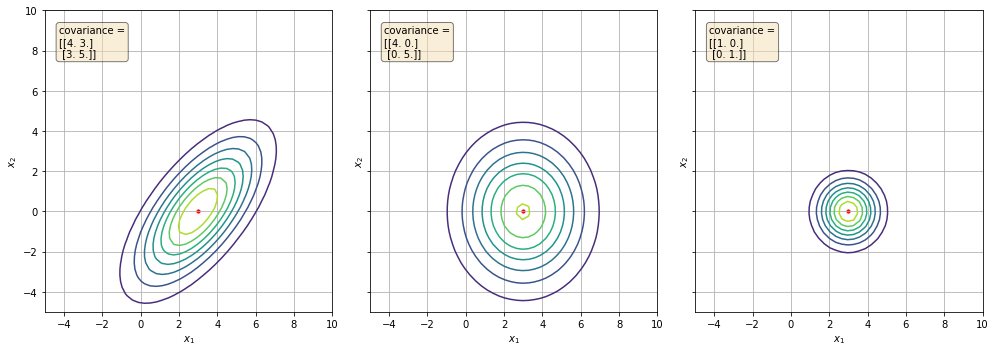

In [9]:
N = 50
mu = np.array([3, 0])
cov1 = np.array([[4., 3.], [3., 5.]])
cov2 = np.array([[4., 0.], [0., 5.]])
cov3 = np.eye(2)

x = np.linspace(-5, 10, num=N)
y = np.linspace(-5, 10, num=N)
x, y = np.meshgrid(x, y)
X = np.dstack([x, y])[:, :, np.newaxis]  # reshape to (*batch, 1, D)

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for ax, cov in zip(axes, (cov1, cov2, cov3)):
    z = Gaussian(X[:, :, np.newaxis], mu, cov)
    ax.contour(x, y, z)
    ax.set_xlim(-5, 10)
    ax.text(0.05, 0.95, f"covariance =\n{cov}", transform=ax.transAxes,
            verticalalignment="top", bbox=props)
    ax.scatter(mu[0], mu[1], c="r", s=10)
    ax.grid(True)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
plt.tight_layout()
plt.show()

## 2.1 MLE

https://stats.stackexchange.com/questions/351549/maximum-likelihood-estimators-multivariate-gaussian

Given dataset $X = (\mathbf{x}_1, \mathbf{x}_2, \cdots, \mathbf{x}_N)^T$, where $\{\mathbf{x_n}\} \sim \mathcal{N}(x_n\vert \mu, \Sigma)$

$\begin{aligned} \text{Log Likelihood} = L(\mu, \Sigma \vert \mathbf{X}) &= \ln p(\mathbf{X} \vert \mu, \Sigma) \\
&= \sum_{n=1}^N \ln \Big( \dfrac{1}{(2\pi)^{D/2}} \dfrac{1}{\vert\Sigma\vert^{1/2}} \exp \big\{-\dfrac{1}{2}(\mathbf{x}_n-\mu)^T\Sigma^{-1}(\mathbf{x}_n-\mu)\big\} \Big) \\
&= -\dfrac{ND}{2} \ln(2\pi) - \dfrac{N}{2} \ln \vert \Sigma \vert - \dfrac{1}{2} \sum_{n=1}^N (\mathbf{x}_n - \mu)^T \Sigma^{-1} (\mathbf{x}_n -\mu) \end{aligned}$

$\begin{aligned} \displaystyle\dfrac{\partial L}{\partial \mu} &= -\sum_{n=1}^N \Sigma^{-1}(\mathbf{x}_n - \mu) = 0 \\
\dfrac{\partial L}{\partial \Sigma^{-1}} &=\dfrac{N}{2}\Sigma - \dfrac{1}{2}\sum_{n=1}^N(\mathbf{x}_n -\mu)(\mathbf{x}_n -\mu)^T = 0
\end{aligned}$

$\begin{aligned} \displaystyle \mu_{ML} &=  \dfrac{1}{N} \sum_{n=1}^N \mathbf{x}_n \\
\hat{\Sigma}_{ML} &= \dfrac{1}{N-1} \sum_{n=1}^N (\mathbf{x}_n - \mu_{ML})(\mathbf{x}_n - \mu_{ML})^T
\end{aligned}$


* single variable

$\begin{aligned} \displaystyle\dfrac{\partial L}{\partial \mu} &= -\sum_{n=1}^N \sigma^{-2}(x_n - \mu) = 0 \\
\dfrac{\partial L}{\partial \sigma} &=\dfrac{N}{2}\sigma^2 - \dfrac{1}{2}\sum_{n=1}^N(x_n -\mu)^2 = 0
\end{aligned}$


In [194]:
np.random.seed(777)
from mpl_toolkits.mplot3d import Axes3D

N = 300
mu = 3  # true mu
var = 4  # true variance
x = np.sort(np.random.normal(loc=mu, scale=np.sqrt(var), size=(N,)))

# mu, var candidates
N_points = 300
mu_hats = np.linspace(1, 5, num=N_points)
var_hats = np.linspace(1, 7, num=N_points)
ll = np.zeros((len(mu_hats), len(var_hats)))

for i in range(len(mu_hats)):
    for j in range(len(var_hats)):
        ll[i, j] = np.sum(np.log(Gaussian(x, mean=mu_hats[i], cov=var_hats[j])))

params = (x, mu_hats, var_hats, ll, N_points)

def draw_points(params, mu_index=None):
    """
    params: (x, mu_hats, var_hats, ll, N_points)
    mu_idx : int or none
    """
    assert isinstance(mu_index, int) or (mu_index is None), "mu_idx = int or none"
    x, mu_hats, var_hats, ll, N_points = params
    if mu_index is None:
        mu_idx = ll.argmax(0)[0]
    else:
        mu_idx = mu_index
    var_idx = ll[mu_idx].argmax()

    fig = plt.figure(figsize=(20, 5))
    ax_ll = fig.add_subplot(131, projection='3d')
    ax_mu = fig.add_subplot(132)
    ax_var = fig.add_subplot(133)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    mu_sel, var_sel = mu_hats[mu_idx], var_hats[var_idx]
    mu_s, var_s = np.meshgrid(mu_hats, var_hats)
    ax_ll.view_init(azim=15)
    ax_ll.plot_surface(mu_s, var_s, ll.T, color="green", alpha=0.3)
    ax_ll.scatter(mu_sel, var_sel, 
                  np.sum(np.log(Gaussian(x, mean=mu_sel, cov=var_sel))), c="r", s=20)
    ax_ll.set_title("Log Likelihood function: $L(\mu, \sigma^2 | X)$")
    ax_ll.set_xlabel("$\mu$")
    ax_ll.set_ylabel("$\sigma^2$")
    ax_ll.set_xticks(np.arange(1, 6))
    
    # scale
    scale_point = 20
    xx_scale_mu = (mu_hats.max() - mu_hats.min()) * (scale_point/N_points)
    xx_scale_var = (var_hats.max() - var_hats.min()) * (scale_point/N_points)
    yy_scale_mu = (ll[:, var_idx].max() - ll[:, var_idx].min()) * (scale_point/N_points)
    yy_scale_var = (ll[mu_idx, :].max() - ll[mu_idx, :].min()) * (scale_point/N_points)
    if mu_index is None:
        xx_sign = 1
        xx_scale_mu = (scale_point/N_points)
    else:
        xx_sign = np.sign(np.sum(np.log(Gaussian(x+(1/N_points), mu_sel, var_sel))) \
                          - np.sum(np.log(Gaussian(x, mu_sel, var_sel))))
    
    # plot mu:
    ax_mu.plot(mu_hats, ll[:, var_idx])
    ax_mu.scatter(mu_sel, ll[mu_idx, var_idx], c="r")
    ax_mu.text(mu_sel - 2*xx_sign*xx_scale_mu, ll[mu_idx, var_idx]-yy_scale_mu, 
               f"$\mu$={mu_sel:.2f}")
    ax_mu.set_title(f"Log Likelihood: $L(\mu | \sigma^2={var_sel:.2f}, X)$")

    # plot var: Given mu, select max var
    ax_var.plot(var_hats, ll[mu_idx, :])
    max_var_ll = ll[mu_idx, :].max()
    ax_var.scatter(var_sel, max_var_ll, c="r")    
    ax_var.text(var_sel-xx_scale_var, max_var_ll-yy_scale_var, f"$\sigma^2$={var_sel:.2f}")
    ax_var.set_title(f"Maximum Log Likelihood: $L(\sigma^2 | \mu={mu_sel:.2f}, X)$")
    plt.show()

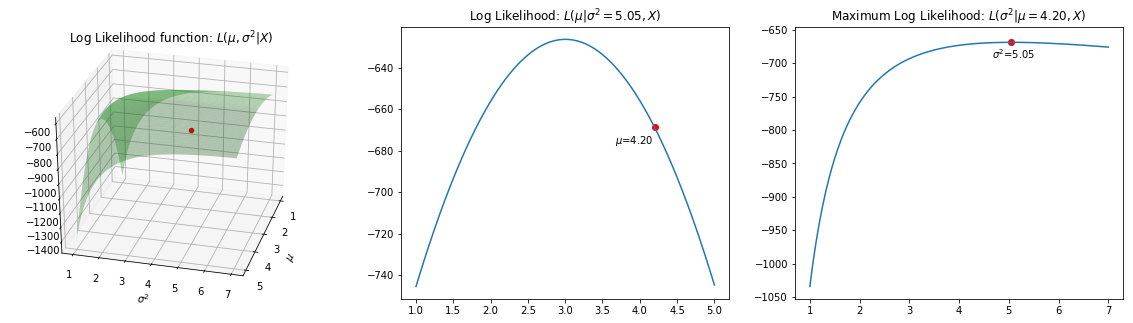

In [195]:
rand_idx = np.random.randint(0, N_points)
draw_points(params, mu_index=rand_idx)

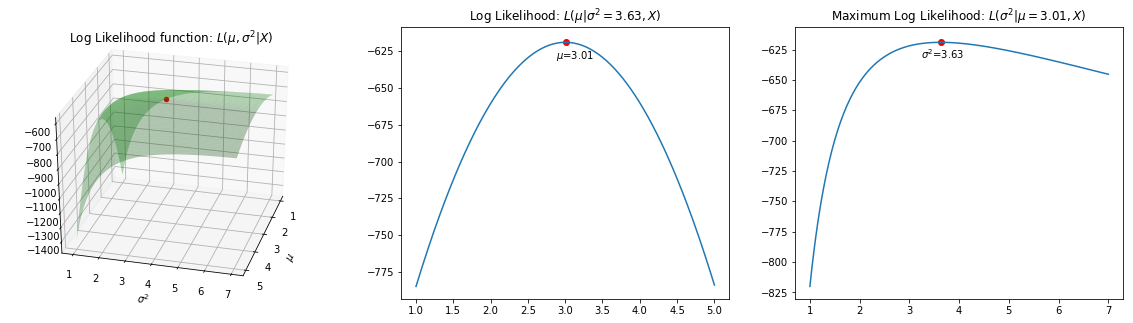

In [196]:
# maximum mu
draw_points(params)

### See sample size effect

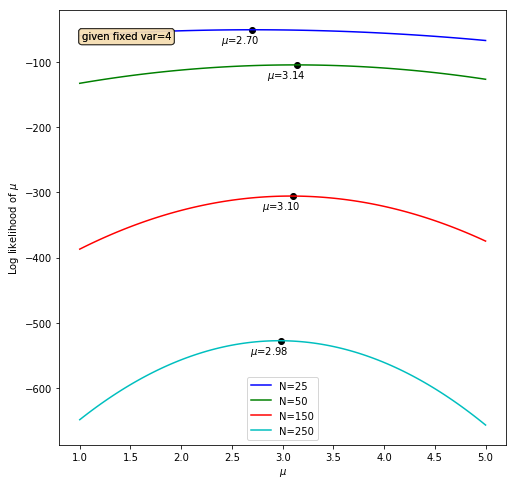

In [118]:
np.random.seed(777)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

colors = ("b", "g", "r", "c")
N = (25, 50, 150, 250)

mu = 3  # true mu
var = 4  # true variance
mu_hats = np.linspace(1, 5, num=100)
mu_ll = np.zeros((4, len(mu_hats)))

for i, (n, c) in enumerate(zip(N, colors)):
    x = np.sort(np.random.normal(loc=mu, scale=np.sqrt(var), size=(n,)))
    for j, m in enumerate(mu_hats):
        mu_ll[i, j] = np.sum(np.log(Gaussian(x, mean=m, cov=var)))
        
    ax.plot(mu_hats, mu_ll[i], c=c, label=f"N={n}")
    max_ll, argmax_ll = mu_ll[i].max(), mu_ll[i].argmax()
    ax.scatter(mu_hats[argmax_ll], max_ll, c="k")
    ax.text(0.05, 0.95, f"given fixed var={var}", transform=ax.transAxes,
            verticalalignment="top", bbox=props)
    ax.text(mu_hats[argmax_ll]-0.3, max_ll-20, f"$\mu$={mu_hats[argmax_ll]:.2f}")
ax.set_xlabel("$\mu$")
ax.set_ylabel("Log likelihood of $\mu$")
ax.legend()
plt.show()

## 2.2 Bayesian

### 1) Given $\sigma^2$, Log Likelihood function of $\mu$

$$L(\mu) = p(\mathbf{x} \vert \mu) = \prod_{n=1}^{N} p(x_n \vert \mu) = \dfrac{1}{(2\pi\sigma^2)^{N/2}} \exp\Big\{ \dfrac{1}{2\sigma^2} \sum_{n=1}^N(x_n-\mu)^2 \Big\}$$

* note that, $p(\mathbf{x} \vert \mu)$ is not the probability function of $\mu$ and not normalized.
* Select a Prior $p(\mu)$ and Posterior for $\mu$: $p(\mu \vert \mathbf{x})$

$$\begin{aligned} 
p(\mu) &= \mathcal{N}(\mu \vert \mu_0, \sigma_0^2)\\
p(\mu \vert \mathbf{x}) &\propto p(\mathbf{x}\vert\mu)p(\mu)
\end{aligned}$$

* Posterior will be like

$$\begin{aligned}
p(\mu \vert \mathbf{x}) &= \mathcal{N}(\mu \vert \mu_N, \sigma_N^2) \\
\text{where} \\
\mu_N &= \dfrac{\sigma^2}{N\sigma_0^2+\sigma^2}\mu_0 + \dfrac{N\sigma_0^2}{N\sigma_0^2+\sigma^2}\mu_{ML} \\
\dfrac{1}{\sigma_N^2} &= \dfrac{1}{\sigma_0^2} + \dfrac{N}{\sigma^2} \\
\mu_{ML} &= \dfrac{1}{N}\sum_{n=1}^N x_n,\quad \text{Maximum Likelihood Estimated value for } \mu
\end{aligned}$$

* when $N \rightarrow 0$, then $\mu \rightarrow \mu_0, \sigma_N^2 \rightarrow \sigma_0^2$
* when $N \rightarrow \infty$, then $\mu \rightarrow \mu_{ML}, \sigma_N^2 \rightarrow \infty$
* for limited $N$, when $\sigma_0^2 \rightarrow \infty$, then $\sigma_N^2 \rightarrow \sigma^2 / N$

* online update: Given Posterior of (N-1) data point and update using N's data
$$p(\mu \vert \mathbf{x}) \propto \Big[ p(\mu) \prod_{n=1}^{N-1} p(x_n \vert \mu) \Big] p(x_N \vert \mu)$$

### 2) Given $\mu$, Log Likelihood function of $\sigma^2 \equiv 1/\lambda$

$$p(\mathbf{X} \vert \lambda) = \prod_{n=1}^N \mathcal{N}(x_n \vert \mu, \lambda^{-1}) \propto \lambda^{N/2} \exp\Big\{ -\dfrac{\lambda}{2}\sum_{n=1}^N(x_n-\mu)^2 \Big\}$$

* Need a Prior, that is "Gamma Distribution"

### Gamma Distribution

$$Gam(\lambda \vert a, b) = \dfrac{1}{\Gamma(a)}b^a\lambda^{a-1} \exp(-b\lambda)$$

* mean, variance:

$$\Bbb{E}[\lambda] = \dfrac{a}{b} \\ var[\lambda] = \dfrac{a}{b^2}$$

* Given Prior $Gam(\lambda\vert a_0, b_0)$, then Posterior will be

$$p(\lambda \vert \mathbf{X})\propto \lambda^{a_0-1}\lambda^{N/2} \exp\Big\{ -b_0\lambda - \dfrac{\lambda}{2}\sum_{n=1}^N(x_n-\mu)^2 \Big\} $$

$$\begin{aligned}
a_N &= a_0 + \dfrac{N}{2} \\
b_N &= b_0 + \dfrac{1}{2}\sum_{n=1}^N(x_n -\mu)^2 = b_0 + \dfrac{N}{2}\sigma_{ML}^2 \\
\sigma_{ML}^2 &= \text{Maximum Likelihood Estimated value for } \sigma^2
\end{aligned}$$

In [197]:
def Gamma(lamb, a, b):
    return gamma(a)**(-1) * b**a * lamb**(a-1) * np.exp(-b*lamb)

/home/simonjisu/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


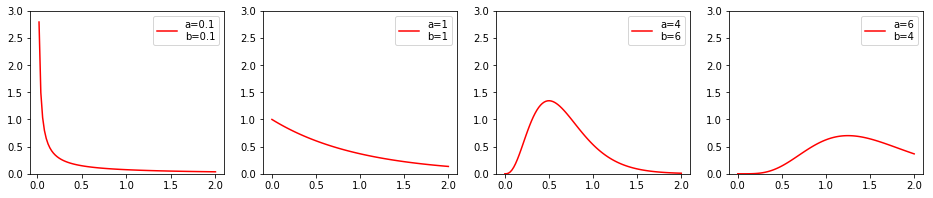

In [200]:
aa = [0.1, 1, 4, 6]
bb = [0.1, 1, 6, 4]
x = np.linspace(0, 2, num=100)

fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=False)
for ax, a, b in zip(axes, aa, bb):
    gamma_value = Gamma(x, a, b)
    ax.plot(x, gamma_value, c="red", label=f"a={a}\nb={b}")
    ax.set_ylim(0, 3)
    ax.legend()

### 3) Don't know both $\mu, \sigma^2$

$$\begin{aligned}
p(\mathbf{X}\vert \mu, \lambda) 
&= \prod_{n=1}^N (\dfrac{\lambda}{2\pi})^{1/2} \exp \Big\{ -\dfrac{\lambda}{2}(x_n-\mu)^2 \Big\}\\
&\propto \Big[ \lambda^{1/2} \exp(-\dfrac{\lambda\mu^2}{2})\Big]^N \exp \Big\{ \lambda \mu\sum_{n=1}^N x_n - \dfrac{\lambda}{2}\sum_{n=1}^N x_n^2 \Big\}
\end{aligned}$$

$$\begin{aligned}
p(\mu, \lambda) &= p(\mu \vert \lambda)p(\lambda) \\
&\propto \Big[ \lambda^{1/2} \exp(-\dfrac{\lambda\mu^2}{2})\Big]^N \exp \Big\{ c\lambda \mu - d\lambda \Big\} \\
&= \exp \Big\{ -\dfrac{\beta\lambda}{2} (\mu - c/\beta)^2 \Big\} \lambda^{\beta/2}\exp\Big\{ -(d-\dfrac{c^2}{2\beta})\lambda\Big\} \\
\text{where }& c, d, \beta \text{ is Constant}
\end{aligned}$$

* it looks like $p(\mu, \lambda) = \mathcal{N}(\mu \vert \mu_0, (\beta\lambda)^{-1})Gam(\lambda \vert a, b)$ called "Gausian Gamma" or "Normal Gamma"
* so, we can define $\mu_0 = c/\beta, a=(1+\beta)/2, b=d-c^2/2\beta$

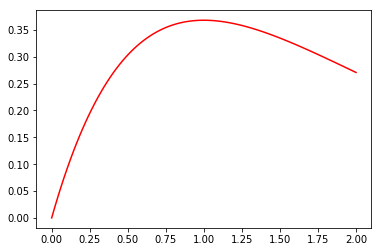

In [213]:
N = 300  # observed number of data
mu = 3  # true mu
var = 4  # true variance
x = np.sort(np.random.normal(loc=mu, scale=np.sqrt(var), size=(N,)))

# mu, var candidates
a, b = (2, 1)  # initial parameters for gamma
N_points = 300
mu_hats = np.linspace(1, 5, num=N_points)
var_hats = np.linspace(1, 7, num=N_points)
ll = np.zeros((len(mu_hats), len(var_hats)))

var = 
lamb = np.linspace(0, 2, num=100)
gamma_value = Gamma(lamb, a=2, b=1)
plt.plot(x, gamma_value, c="red", label=f"a={a}\nb={b}")

In [109]:
from scipy import stats
rv = stats.multivariate_normal(mu, cov)
a = rv.pdf(np.dstack([x, y]))

---

## How to calculate eigen vectors

In [71]:
A = np.array([[4, 3], 
              [3, 5]])
eigen1, eigen2 = np.roots([1, -9, 11])
eigen1.round(2), eigen2.round(2)

(7.54, 1.46)

In [72]:
B1 = A - eigen1 * np.eye(2)
B2 = A - eigen2 * np.eye(2)
print(B1.round(2))
print()
print(B2.round(2))

[[-3.54  3.  ]
 [ 3.   -2.54]]

[[2.54 3.  ]
 [3.   3.54]]


In [73]:
temp = B1.copy()
# Row reduction:
# -R2[0]/R1[0] * R1 + R2 --> R2
temp[1, :] = (-B1[1, 0]/B1[0, 0])*B1[0, :] + B1[1, :]
print("After row reduction")
print(temp.round(2))

# eigen_vector relationship: 
# -4.85 * x_1 + 3 * x_2 = 0
# let x_1 = 1
x_1 = 1
x_2 = (-temp[0, 0] * x_1) / temp[0, 1]
eigen_v1 = np.array([[x_1], [x_2]])
print("eigen vector if eigen value is 6.85")
print(eigen_v1.round(2))

After row reduction
[[-3.54  3.  ]
 [ 0.    0.  ]]
eigen vector if eigen value is 6.85
[[1.  ]
 [1.18]]


In [74]:
temp = B2.copy()
# Row reduction:
# -R2[0]/R1[0] * R1 + R2 --> R2
temp[1, :] = (-B2[1, 0]/B2[0, 0])*B2[0, :] + B2[1, :]
print("After row reduction")
print(temp.round(2))

# eigen_vector relationship: 
# 1.85 * x_1 + 3 * x_2 = 0
# let x_1 = 1
x_1 = 1
x_2 = (-temp[0, 0] * x_1) / temp[0, 1]
eigen_v2 = np.array([[x_1], [x_2]])
print("eigen vector if eigen value is 0.15")
print(eigen_v2.round(2))

After row reduction
[[ 2.54  3.  ]
 [ 0.   -0.  ]]
eigen vector if eigen value is 0.15
[[ 1.  ]
 [-0.85]]


In [75]:
e_val = np.array((eigen2, eigen1))
e_vec = np.concatenate((eigen_v2, eigen_v1), axis=1) 
e_vec = e_vec / (np.linalg.norm(e_vec[:, 0]), np.linalg.norm(e_vec[:, 1]))  # noramlizing

print("Eigen value:")
print(e_val)
print("Eigen vector for each eigen value(column vector)")
print(e_vec)

Eigen value:
[1.45861873 7.54138127]
Eigen vector for each eigen value(column vector)
[[ 0.76301998  0.6463749 ]
 [-0.6463749   0.76301998]]


In [76]:
# same result as numpy "eig" function
e_val_np, e_vec_np = np.linalg.eig(A)
print("Eigen value:")
print(e_val_np)
print("Eigen vector for each eigen value(column vector)")
print(e_vec_np)

Eigen value:
[1.45861873 7.54138127]
Eigen vector for each eigen value(column vector)
[[-0.76301998 -0.6463749 ]
 [ 0.6463749  -0.76301998]]


In [77]:
# V: eigen vector matrix, L: eigen value only on diagonal term, *: dotproduct(only here)
# A*V = V*L
I = np.eye(2)
L = e_val*I
print("A*V")
print(A.dot(e_vec))
print()
print("V*L")
print(e_vec.dot(L))
print()

# which means that 
# A = V*L*V^{-1}
print("V*L*V^{-1}")
print(e_vec.dot(L).dot(np.linalg.inv(e_vec)))
print()
# Also "V^{-1} == V^T"
print("V^{-1} == V^T")
print(np.linalg.inv(e_vec).round(3) == e_vec.T.round(3))
print()

A*V
[[ 1.11295524  4.87455953]
 [-0.94281453  5.7542246 ]]

V*L
[[ 1.11295524  4.87455953]
 [-0.94281453  5.7542246 ]]

V*L*V^{-1}
[[4. 3.]
 [3. 5.]]

V^{-1} == V^T
[[ True  True]
 [ True  True]]



In [87]:
def draw_multi_gaussian(mu, cov, e_val=None, e_vec=None, n=5000, limits=None):
    """
    only for 2d
    n : sample size
    e_val : eigen value vector
    e_vec : eigen vector matrix (combination of column vector)
    limits : axis limits [0]: x-axis, [1]: y-axis
    """
    arrow_d = dict(facecolor="r", edgecolor="r", width=0.3, headwidth=5,
                   headlength=8)
    x = np.random.multivariate_normal(mean=mu, cov=cov, size=(n))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(x[:, 0], x[:, 1], c="g", s=10, alpha=0.3)
    if e_vec is not None and e_val is not None:
        ax.annotate("", xy=(mu + e_val[0]*e_vec[:, 0]), xytext=mu, arrowprops=arrow_d) 
        ax.annotate("", xy=(mu + e_val[1]*e_vec[:, 1]), xytext=mu, arrowprops=arrow_d) 
    if limits is not None:
        ax.set_xlim(*limits[0])
        ax.set_ylim(*limits[1])
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    plt.show()

[[1.45861873 0.        ]
 [0.         7.54138127]]


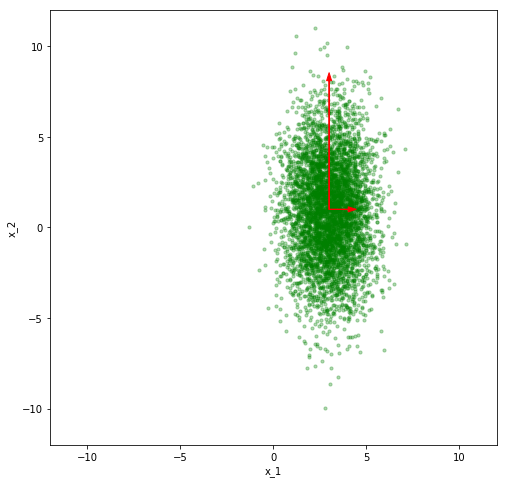

In [88]:
limits = [(-12, 12), (-12, 12)]

# in PRML they set the sigma very simple,
# let V = I (identity matrix)
# then, A = L, which means 0 for non diagonal terms
print(L)
mu = np.array([3, 1])
draw_multi_gaussian(mu, L, e_val=e_val, e_vec=I, limits=limits)

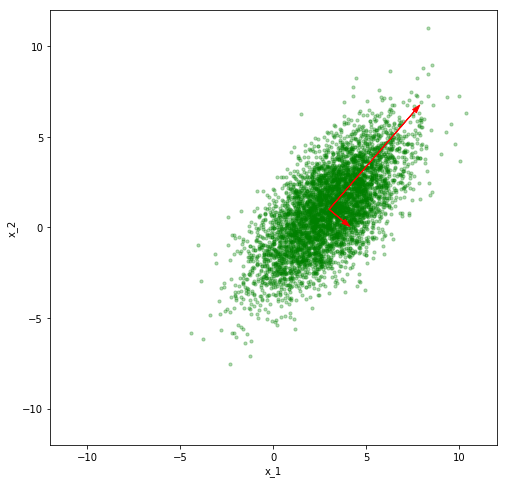

In [89]:
# this example: A
draw_multi_gaussian(mu, A, e_val=e_val, e_vec=e_vec, limits=limits)

---

backup

In [ ]:
def Gaussian(x, mean, cov):
    """
    x : last dimension must be number of variable demension (*batch, 1, D), D is dimension of random variable x
        For instance 1-D shape should be (N, 1, 1)
    mean : D-dimension mean vector
    cov : covariance
    """
    assert isinstance(x, np.ndarray), "input must be np.ndarray"
    if x.ndim == 1:
        assert isinstance(mean, int) * isinstance(cov, int) == 1, \
            "both 'mean' or 'cov' be int or not, if 1-dim input"
        return (2*np.pi*cov)**(-1/2) * np.exp(-(1/(2*cov))*(x-mean)**2)
    else:
        assert x.shape[-2] == 1, "must be a row vector, so x.shape[-2]==1"
        N_dims = len(x.shape)
        D = x.shape[-1]
        # mahalanobis distance: \Delta^2
        trans_axes = list(range(N_dims-2)) + [N_dims-1, N_dims-2]
        distance = np.squeeze((1/2)*np.matmul((x - mean).dot(np.linalg.inv(cov)), np.transpose((x - mean), axes=trans_axes)))
        return (2*np.pi)**(-D/2)*np.linalg.det(cov)**(1/2)*np.exp(-distance)